General overview of this notebook that aims to balance the emotion images used for training the best model previously found.

- Cleaning Prior Runs:
    The code starts by cleaning up artifacts from previous runs. It removes any augmented images and restores the original images to their respective folders.

- Image Augmentation for Balancing:
    Augmentations are performed on images until a desired minimum target count (in this case, 10,000) is reached.
    Augmentation techniques include rotation, width shift, height shift, shear, zoom, and horizontal flip.
    Augmented images have a size of 48x48 pixels and a filename prefix "_augmented".

- Summarizing Image Distribution:
    The code uses a function (summarize_images) to summarize the distribution of images. This likely includes counting the number of images, their sizes, or other relevant details.

- Reducing Image Count in Exceeding Folders:
    A function (reduce_images) is employed to reduce the count of images in folders exceeding the target count. This involves moving the smallest files to an archive folder.

- Displaying Final Image Distribution:
    The final distribution of original and augmented images is displayed. This provides an overview of the balanced dataset.

- Training Phase:
    Augmented images are loaded for training using TensorFlow's ImageDataGenerator.
    The best model is trained again using the optimizers found earlier and the same architecture but with the balanced dataset.
    Training data is saved to the "training/final" folder, training history to "training/history", and checkpoints to "training/checkpoint".

- Model Evaluation:
    The model is evaluated with a confusion matrix to analyze the distribution of true and predicted labels.

- Creating Dataframe of Training History:
    A dataframe is created from the training history, showing the last 10 epochs. Accuracy and loss for both training and validation are plotted.

- Plotting ROC Curve:
    The Micro- & Macro-averaging ROC Curve is plotted with AUC for the balanced emotion model.

- Final Model Evaluation:
    The model's performance is evaluated on the test set, and accuracy metrics are printed.

This code focuses on preparing and training a model on a balanced dataset, with a particular emphasis on handling imbalanced emotion classes through augmentation and subsequent evaluation.

In [1]:
# Import necessary modules for file and directory operations
import os
import glob
import shutil

# Configure TensorFlow logging level to control verbosity
# Suppress warnings to avoid cluttering the output
# TF_CPP_MIN_LOG_LEVEL is set to '2' to hide INFO messages
# Set it to '3' to additionally suppress all warnings

# Note: Controlling logging level is essential for a clean and concise output during script execution.
# It helps users focus on relevant information and reduces unnecessary verbosity.
# Setting to '2' ensures that INFO messages are hidden, leaving only more critical warnings and errors visible.
# Adjust this setting based on the desired balance between information and verbosity.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to additionally suppress all warnings

In [2]:
# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Loop through each emotion and remove all files containing '_augmented_'
for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)

    # Get a list of all files containing '_augmented_' in the emotion folder
    files_to_remove = glob.glob(os.path.join(emotion_path, '*_augmented_*'))

    # Remove each file
    for file_path in files_to_remove:
        os.remove(file_path)

    print(f'{emotion}: All files containing "_augmented_" removed successfully.')

    # Check if 'archive_images_emotion' folder is present
    archive_emotion_folder_path = os.path.join(dataset_path, 'archive_images_' + emotion)
    if os.path.exists(archive_emotion_folder_path):
        # Move contents of 'archive_images_emotion' to the emotion folder
        files_in_archive_emotion = glob.glob(os.path.join(archive_emotion_folder_path, '*'))
        for file_in_archive_emotion in files_in_archive_emotion:
            destination_path = os.path.join(emotion_path, os.path.basename(file_in_archive_emotion))
            shutil.move(file_in_archive_emotion, destination_path)

        # Remove 'archive_images_emotion' folder
        os.rmdir(archive_emotion_folder_path)
        print(f'{emotion}: Contents of "archive_images_{emotion}" moved to parent folder and folder deleted.')

print("Cleanup completed.")


angry: All files containing "_augmented_" removed successfully.
disgust: All files containing "_augmented_" removed successfully.
fear: All files containing "_augmented_" removed successfully.
happy: All files containing "_augmented_" removed successfully.
neutral: All files containing "_augmented_" removed successfully.
sad: All files containing "_augmented_" removed successfully.
surprise: All files containing "_augmented_" removed successfully.
Cleanup completed.


In [3]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator
import os
import glob
import pandas as pd

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

# Define the emotions and their respective folders
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Specify the minimum number of images you want in each class after augmentation
min_images_per_class = 10000

# Create a DataFrame to store the image file paths and their corresponding labels
data = {'file_path': [], 'emotion': []}

for emotion in emotions:
    emotion_path = os.path.join(dataset_path, emotion)
    image_paths = glob.glob(os.path.join(emotion_path, '*.jpg'))
    data['file_path'].extend(image_paths)
    data['emotion'].extend([emotion] * len(image_paths))

df = pd.DataFrame(data)

# Dictionary to store the count of augmented images per emotion
augmented_count = {}

for emotion in emotions:
    augmented_count[emotion] = 0

# Create an ImageDataGenerator with your desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each emotion and perform augmentation
for emotion in emotions:
    # Filter the DataFrame to include only the current emotion
    subset_df = df[df['emotion'] == emotion]

    # Exclude previously augmented images from the DataFrame
    subset_df = subset_df[~subset_df['file_path'].str.contains('_augmented')]

    # Calculate the number of augmentations needed
    augmentations_needed = max(0, min_images_per_class - len(subset_df))

    # Create a flow_from_dataframe generator
    generator = datagen.flow_from_dataframe(
        subset_df,
        directory=None,  # We provide the full file paths in 'file_path' column
        x_col='file_path',
        y_col='emotion',
        target_size=(48, 48),
        batch_size=1,
        class_mode='categorical',
        save_to_dir=os.path.join(dataset_path, emotion),
        save_prefix=emotion + '_augmented',
        save_format='jpg'
    )

    # Generate augmented images only if augmentations are needed
    if augmentations_needed > 0:
        for i in range(augmentations_needed):
            batch = generator.next()

        # Get the count of augmented images generated
        augmented_count[emotion] = i + 1

        print(f'{emotion}: {augmented_count[emotion]} augmented images generated successfully.\n')
    else:
        print(f'{emotion}: 0 augmented images generated. No augmentations needed.\n')

# Print the total count of augmented images per emotion
print("\nTotal Augmented Images per Emotion:")
for emotion, count in augmented_count.items():
    print(f'{emotion}: {count}')


Found 6566 validated image filenames belonging to 1 classes.
angry: 3434 augmented images generated successfully.

Found 3231 validated image filenames belonging to 1 classes.
disgust: 6769 augmented images generated successfully.

Found 4859 validated image filenames belonging to 1 classes.
fear: 5141 augmented images generated successfully.

Found 28592 validated image filenames belonging to 1 classes.
happy: 0 augmented images generated. No augmentations needed.

Found 29384 validated image filenames belonging to 1 classes.
neutral: 0 augmented images generated. No augmentations needed.

Found 12223 validated image filenames belonging to 1 classes.
sad: 0 augmented images generated. No augmentations needed.

Found 8113 validated image filenames belonging to 1 classes.
surprise: 1887 augmented images generated successfully.


Total Augmented Images per Emotion:
angry: 3434
disgust: 6769
fear: 5141
happy: 0
neutral: 0
sad: 0
surprise: 1887


In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = "../dataset/MMAFEDB/train/"

def summarize_images(folder, save_path, sup_title_model,show_size_only=False):
    total_images = 0
    emotion_counts = {}
    augmented_counts = {}
    archive_folder_name = 'archive_images'

    for root, dirs, files in os.walk(folder):
        # Exclude 'archive_images' folders from processing
        dirs = [d for d in dirs if not d.startswith(archive_folder_name)]

        for file in files:
            if file.endswith(".jpg"):
                file_path = os.path.join(root, file)

                # Extract emotion from the path
                emotion = os.path.basename(os.path.dirname(file_path))

                total_images += 1

                # Skip 'archive_images' folders
                if emotion.startswith(archive_folder_name):
                    continue

                # Count per emotion
                if emotion in emotion_counts:
                    emotion_counts[emotion] += 1
                else:
                    emotion_counts[emotion] = 1

                # Count augmented images per emotion
                if "_augmented_" in file:
                    if emotion in augmented_counts:
                        augmented_counts[emotion] += 1
                    else:
                        augmented_counts[emotion] = 1

    print('###########################')
    print(f"Folder: {folder}")
    print(f"Total Images: {total_images}")

    print("\nCount per emotion:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}")

    print("\nCount of Augmented Images per Emotion:")
    for emotion, count in augmented_counts.items():
        print(f"{emotion}: {count}")

    # Plotting the stacked bar count using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), label="Original")
    sns.barplot(x=list(augmented_counts.keys()), y=list(augmented_counts.values()), label="Augmented", color='orange')
    plt.title("Count of Images (Original and Augmented) per Emotion")
    plt.suptitle(sup_title_model)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.legend()

    plt.savefig(save_path)

    plt.show()

    return {
        "total_images": total_images,
        "emotion_counts": emotion_counts,
        "augmented_counts": augmented_counts
    }

/home/fox/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110199

Count per emotion:
neutral: 29384
angry: 10000
fear: 10000
happy: 28592
disgust: 10000
sad: 12223
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3434
fear: 5141
disgust: 6769
surprise: 1887


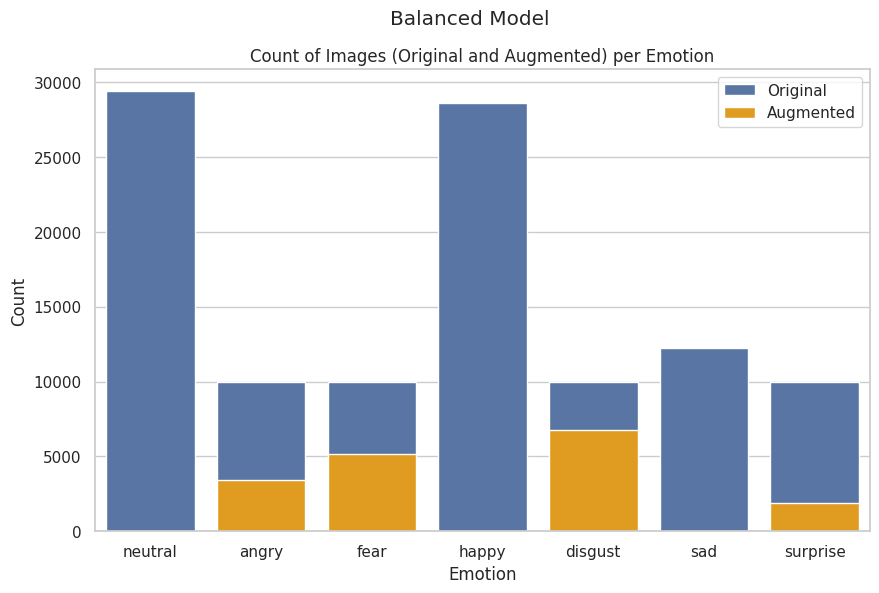

In [5]:
# Summarize images in the train folder
summary_train_dir = summarize_images(
    dataset_path,
    save_path='../images/balanced_before_trim.png',
    sup_title_model='Balanced Model')

In [6]:
import os
import shutil

def move_smallest_to_archive_per_emotion(folder, target_count=10000):
    # Define the list of emotions to process
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    # Define the name for the archive folder
    archive_folder_name = 'archive_images'

    # Loop through each emotion and check file counts
    for emotion in emotions:
        emotion_folder = os.path.join(folder, emotion)

        # Check if the emotion folder exists
        if os.path.exists(emotion_folder):
            # List files in the emotion folder, sorted by size
            files_sorted_by_size = sorted(os.listdir(emotion_folder), key=lambda x: os.path.getsize(os.path.join(emotion_folder, x)))

            # Check if the emotion folder exceeds the target count
            count_to_move = max(0, len(files_sorted_by_size) - target_count)

            if count_to_move > 0:
                # Create 'archive_images_emotion' folder inside the parent folder if it doesn't exist
                archive_emotion_folder = os.path.join(folder, f"{archive_folder_name}_{emotion}")
                if not os.path.exists(archive_emotion_folder):
                    os.makedirs(archive_emotion_folder)

                # Move files to 'archive_images_emotion' folder
                for file_to_move in files_sorted_by_size[:count_to_move]:
                    source_path = os.path.join(emotion_folder, file_to_move)
                    destination_path = os.path.join(archive_emotion_folder, file_to_move)
                    shutil.move(source_path, destination_path)

                print(f"Moved {count_to_move} smallest files to '{archive_folder_name}_{emotion}' folder.")
            else:
                print(f"No files moved in '{emotion}' emotion folder as the count is within the target.")

        else:
            print(f"'{emotion}' emotion folder not found.")

# Call the defined function
move_smallest_to_archive_per_emotion(dataset_path)

No files moved in 'angry' emotion folder as the count is within the target.
No files moved in 'disgust' emotion folder as the count is within the target.
No files moved in 'fear' emotion folder as the count is within the target.
Moved 18592 smallest files to 'archive_images_happy' folder.
Moved 19384 smallest files to 'archive_images_neutral' folder.
Moved 2223 smallest files to 'archive_images_sad' folder.
No files moved in 'surprise' emotion folder as the count is within the target.


###########################
Folder: ../dataset/MMAFEDB/train/
Total Images: 110199

Count per emotion:
neutral: 10000
angry: 10000
fear: 10000
happy: 10000
disgust: 10000
sad: 10000
surprise: 10000

Count of Augmented Images per Emotion:
angry: 3434
fear: 5141
disgust: 6769
surprise: 1887


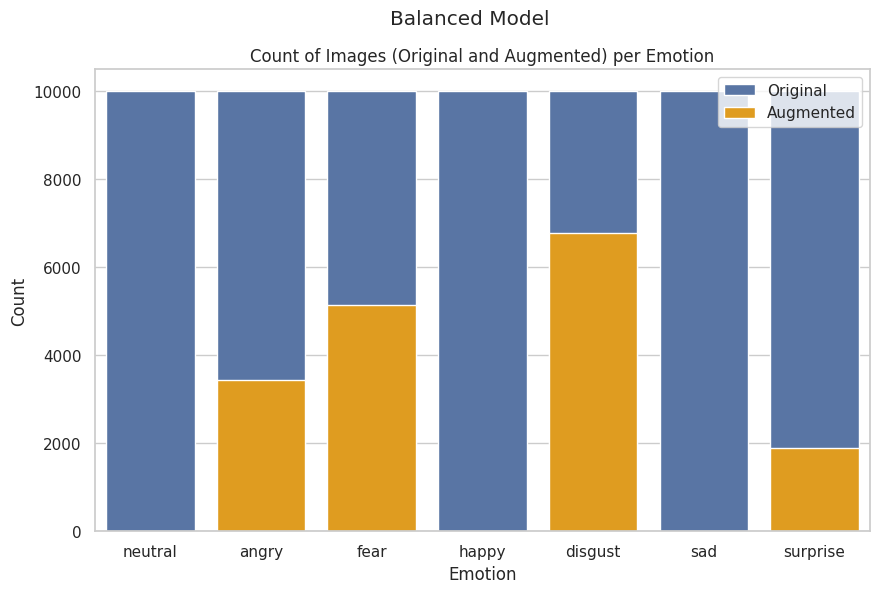

In [7]:
# Summarize images in the train folder
summary_train_dir = summarize_images(
    dataset_path,
    save_path='../images/balanced_after_trim.png',
    sup_title_model='Balanced Model')

In [8]:
# Retraining the best model that was found with balanced dataset

## Best peforming model based on validation accuracy is model_2_best_sgd_rgb_128_augment
best_model_name = 'model_2_best_sgd_rgb_128'

import os
import json

# Recreate the exact same model, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import scikitplot as skplt


# Due to file upload limitation the ckpt file is now loaded with json_file model architecture and weights.
# Load architecture from JSON file
with open("../models/best_model/best_model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()

keras_best_model = tf.keras.models.model_from_json(loaded_model_json)

# Image Specifications
folder_path = "../dataset/MMAFEDB/"
image_dimension = (48, 48)
image_color_mode = 'rgb'
batch_size = 128

# Define the list of classes (emotions)
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

# Create validation image generator and normalize images
datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory to load the images into the pipeline
train_set = datagen.flow_from_directory(
    folder_path + "train",
    target_size=image_dimension,
    color_mode=image_color_mode,
    class_mode='categorical',
    classes=classes,
    shuffle=True,
    batch_size=batch_size
)

test_set = datagen.flow_from_directory(
    folder_path + "test",
    target_size=image_dimension,
    color_mode=image_color_mode,
    class_mode='categorical',
    classes=classes,
    shuffle=False,
    batch_size=1
)

# Get the total number of images in the training set
total_images_train = train_set.n
print("Total images in training set:", total_images_train)
# Get the total number of images in the test set
total_images_test = test_set.n
print("Total images in test set:", total_images_test)

Found 70000 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Total images in training set: 70000
Total images in test set: 17356


In [9]:
## TRANING USING BALANCED EMOTION DATASET! 10,000 Images per emotion class = 70,000 total
# Best model parameters
augment = 'balanced'
optimizer = {
            'adam': tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
            'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
            'sgd': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
        }
loss = 'categorical_crossentropy'
metrics = ['accuracy']
selected_optimizer = 'sgd'

# Compile the keras model
keras_best_model.compile(
            optimizer=optimizer[selected_optimizer],
            loss=loss,
            metrics=metrics
        )

# Show the model architecture / summary
keras_best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                      

In [10]:
# Start model training!
# Define hyperparameters
# best_model_name = 'model_2_best_sgd_rgb_128'
folder_path_models = "../models/"
checkpoint_filename = folder_path_models+f"training/checkpoint/{best_model_name}_{augment}_cpt.h5"
epochs = 50
monitor='val_accuracy'
mode='max'

# Set up model checkpoint
print('\nSetting up checkpoint file for incremental validation accuracy improvements')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    mode=mode
)
callbacks_list = [checkpoint]

# Train the model
print(f'********************** Model training started! ********************')
history = keras_best_model.fit(
    train_set,
    validation_data=test_set,
    steps_per_epoch=total_images_train // batch_size,
    validation_steps=total_images_test // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)
print(f'********************** Model training finished! ********************')

# Saving final model after train epochs have completed
final_filename = folder_path_models+f"training/final/{best_model_name}_{augment}_final.h5"
print(f'Saving final model to {final_filename}')
keras_best_model.save_weights(final_filename)

# Saving training history to file
history_filename = folder_path_models+f"training/history/{best_model_name}_{augment}_history.json"
with open(history_filename, 'w') as history_file:
    json.dump(history.history, history_file)
    print(f'Saved model.fit training history to {history_filename}')

# End of training loop!
print('########################################################################################')
print('##################### Loop has finished for current model file! ########################')
print('########################################################################################')


Setting up checkpoint file for incremental validation accuracy improvements
********************** Model training started! ********************
Epoch 1/50


2024-02-20 14:13:16.774946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


546/546 [==============================] - ETA: 0s - loss: 2.3038 - accuracy: 0.3144
Epoch 1: val_accuracy improved from -inf to 0.24444, saving model to ../models/training/checkpoint/model_2_best_sgd_rgb_128_balanced_cpt.h5


/home/fox/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


546/546 [==============================] - 40s 59ms/step - loss: 2.3038 - accuracy: 0.3144 - val_loss: 2.1062 - val_accuracy: 0.2444
Epoch 2/50
546/546 [==============================] - ETA: 0s - loss: 2.2453 - accuracy: 0.3700
Epoch 2: val_accuracy did not improve from 0.24444
546/546 [==============================] - 30s 56ms/step - loss: 2.2453 - accuracy: 0.3700 - val_loss: 16.5655 - val_accuracy: 0.0000e+00
Epoch 3/50
546/546 [==============================] - ETA: 0s - loss: 2.3694 - accuracy: 0.3640
Epoch 3: val_accuracy improved from 0.24444 to 0.68148, saving model to ../models/training/checkpoint/model_2_best_sgd_rgb_128_balanced_cpt.h5
546/546 [==============================] - 30s 56ms/step - loss: 2.3694 - accuracy: 0.3640 - val_loss: 1.1246 - val_accuracy: 0.6815
Epoch 4/50
546/546 [==============================] - ETA: 0s - loss: 2.1390 - accuracy: 0.3672
Epoch 4: val_accuracy did not improve from 0.68148
546/546 [==============================] - 31s 56ms/step - loss

In [10]:
# Loading weights from above trained model (so we don't have to rerun training!)
# The weights saved above have been moved to the directory that is used below and renamed.
keras_best_model.load_weights('../models/best_model/best_weights_balanced_dataset.h5')

In [11]:
# Label encodings
labels = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happiness",
    4: "sadness",
    5: "surprise",
    6: "neutral",
}

label_list = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]

# Load the true labels from the test set, important to have shuffle set to False!
y_test = test_set.classes

# Predict probabilities for each class using the model
y_pred_prob = keras_best_model.predict(test_set)    

# Get predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode labels
y_test_decoded = np.vectorize(labels.get)(y_test)
y_pred_decoded = np.vectorize(labels.get)(y_pred)

# Print decoded labels
print(y_test_decoded)
print(y_pred_decoded)

17356/17356 [==============================] - 25s 1ms/step
['anger' 'anger' 'anger' ... 'neutral' 'neutral' 'neutral']
['anger' 'sadness' 'anger' ... 'surprise' 'neutral' 'neutral']


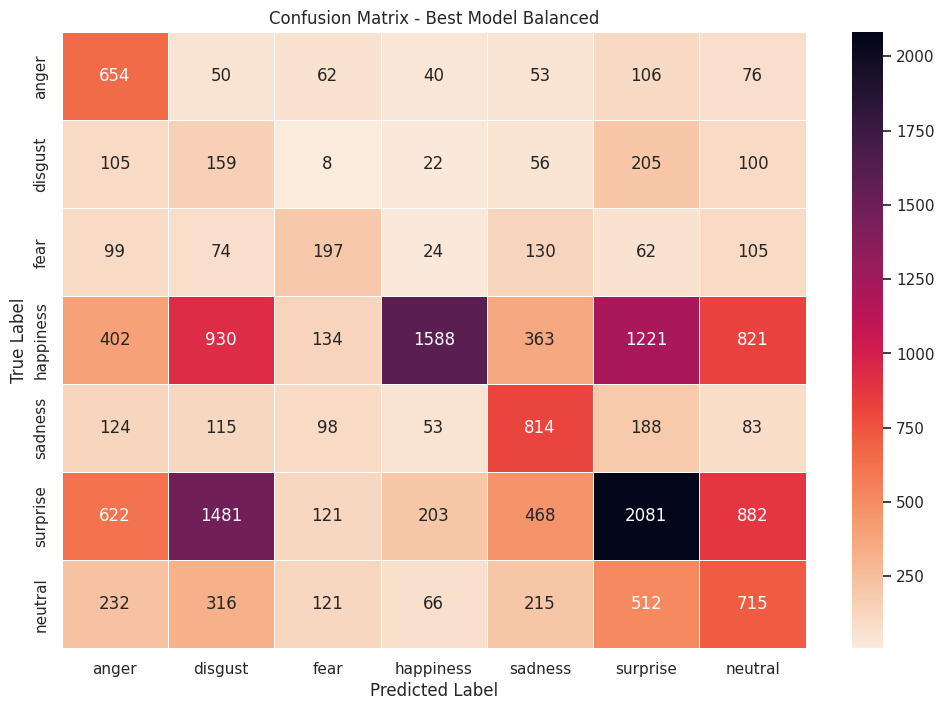

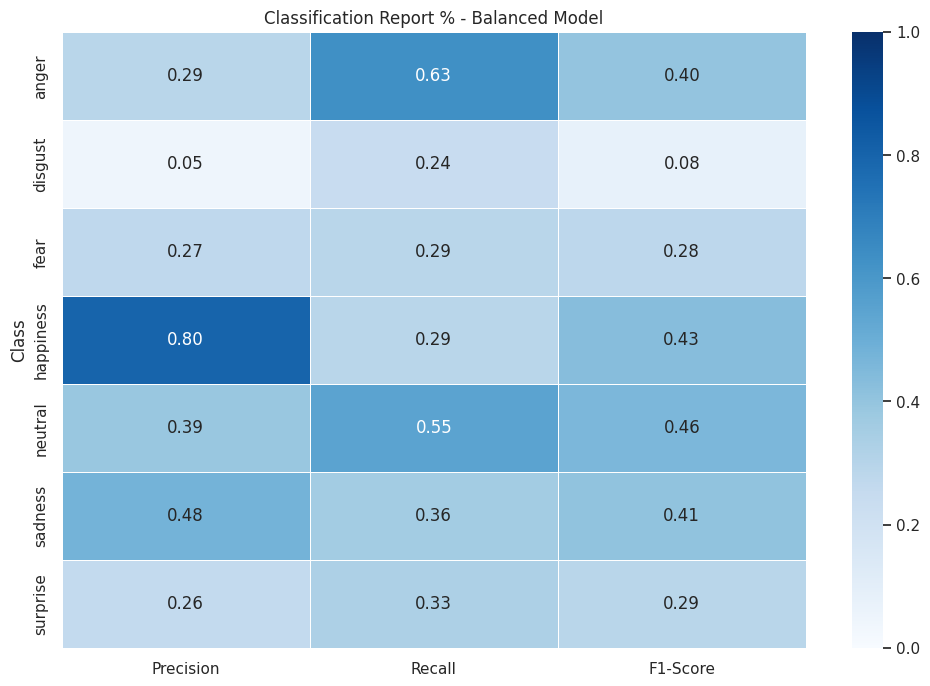

Number of wrong validation predictions (out of 17356): 11148
Accuracy of validation prediction: 35.77%
Label-encodings:  {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Create a figure
fig, ax = plt.subplots(figsize=(12,8))

# Plot confusion matrix
cm = confusion_matrix(y_true=y_test_decoded,y_pred=y_pred_decoded)
cm_df = pd.DataFrame(cm,label_list,label_list)                      
sns.heatmap(cm_df, annot=True,fmt='d',linewidth=.5,cmap='rocket_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Best Model Balanced')

# Save the figure
plt.savefig("../images/confusion_matrix_best_model_balanced.png")

# Show the figure
plt.show()

# Display classification report with zero_division parameter
report = classification_report(
    y_test_decoded,
    y_pred_decoded,
    zero_division=1  # Set to 1 or 'warn' or any numeric value you prefer
)

# Parse the classification report to extract precision, recall, and f1-score
report_lines = report.split('\n')[2:-5]
data = []
for line in report_lines:
    row = line.split()
    class_name, precision, recall, f1_score, _ = row
    data.append([class_name, float(precision), float(recall), float(f1_score)])

# Create a DataFrame from the extracted data
df = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score'])

# Create a Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.set_index('Class'), annot=True, cmap="Blues", fmt=".2f", linewidths=.5, annot_kws={"size": 12}, vmin=0, vmax=1)
plt.title('Classification Report % - Balanced Model')

# Save the figure
plt.savefig("../images/classification_report_best_model_balanced.png")

# Show the figure
plt.show()

# Count total incorrect predictions
incorrect_predictions = np.sum(y_test != y_pred)

# Display total wrong validation predictions
print(f"Number of wrong validation predictions (out of {len(y_test)}): {incorrect_predictions}")
accuracy = ((len(y_test) - incorrect_predictions) / len(y_test) * 100)
rounded_accuracy = round(accuracy, 2)
print(f"Accuracy of validation prediction: {rounded_accuracy}%")

# Display label encodings
print('Label-encodings: ', labels)

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Read the json history file of the best balanced model
with open('../models/training/history/model_2_best_sgd_rgb_128_balanced_history.json','r') as file:
    data = json.load(file)

# Save name in variable
model_name = 'model_2_best_sgd_rgb_128_balanced'

# Create the DataFrame directly
df = pd.DataFrame({
    'epoch': range(1,51), 
    'loss':data['loss'], 
    'accuracy':data['accuracy'], 
    'val_loss':data['val_loss'],
    'val_accuracy':data['val_accuracy']
})

# Set the dataframe index to epoch
df.index = df['epoch']
# Drop the old epoch column
df.drop(columns='epoch',inplace=True)

# Display the DataFrame
print(f'{model_name}:\n',df.tail(10))

model_2_best_sgd_rgb_128_balanced:
            loss  accuracy  val_loss  val_accuracy
epoch                                            
41     0.430816  0.841639  1.214956      0.681481
42     0.416537  0.846233  1.040994      0.681481
43     0.400160  0.851743  1.367418      0.659259
44     0.376421  0.862177  1.241797      0.644444
45     0.783525  0.742830  1.481492      0.533333
46     0.492623  0.817710  1.601383      0.592593
47     0.404417  0.850169  1.184871      0.711111
48     0.377522  0.861976  1.109300      0.711111
49     0.354912  0.869991  1.292520      0.718518
50     0.338385  0.875988  1.407153      0.688889


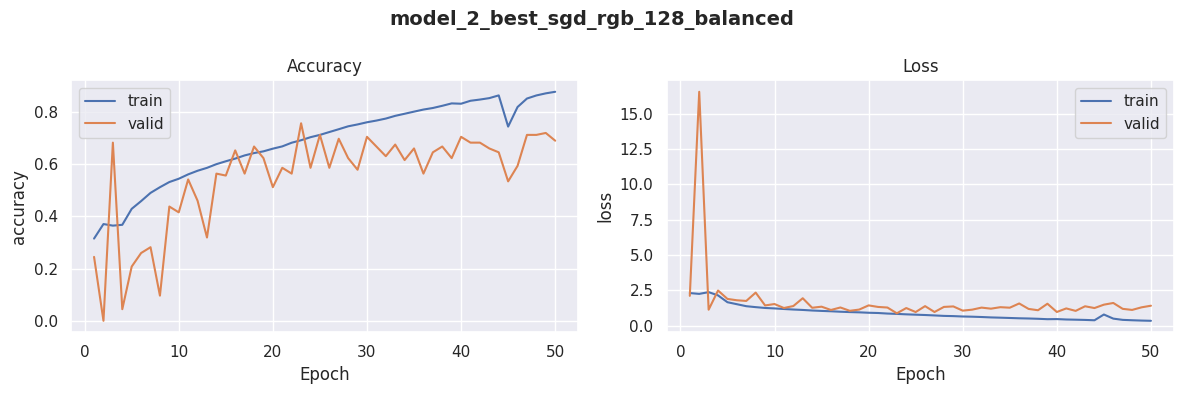

In [15]:
# Create a figure for plotting
sns.set()
fig = plt.figure(0, (12, 4))

# Set the title to the model name
plt.suptitle(model_name,weight='bold', fontsize=14)

# Create a sub-plots for the figure accuracy
ax = plt.subplot(1, 2, 1)
sns.lineplot(x=df.index, y=df['accuracy'], label='train')
sns.lineplot(x=df.index, y=df['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.tight_layout()

# Create a sub-plots for the figure loss
ax = plt.subplot(1, 2, 2)
sns.lineplot(x=df.index, y=df['loss'], label='train')
sns.lineplot(x=df.index, y=df['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch')
plt.tight_layout()

# Save the figure as png for reference
plt.savefig('../images/best_model_metrics_balanced.png')
plt.show()

<Figure size 1500x500 with 0 Axes>

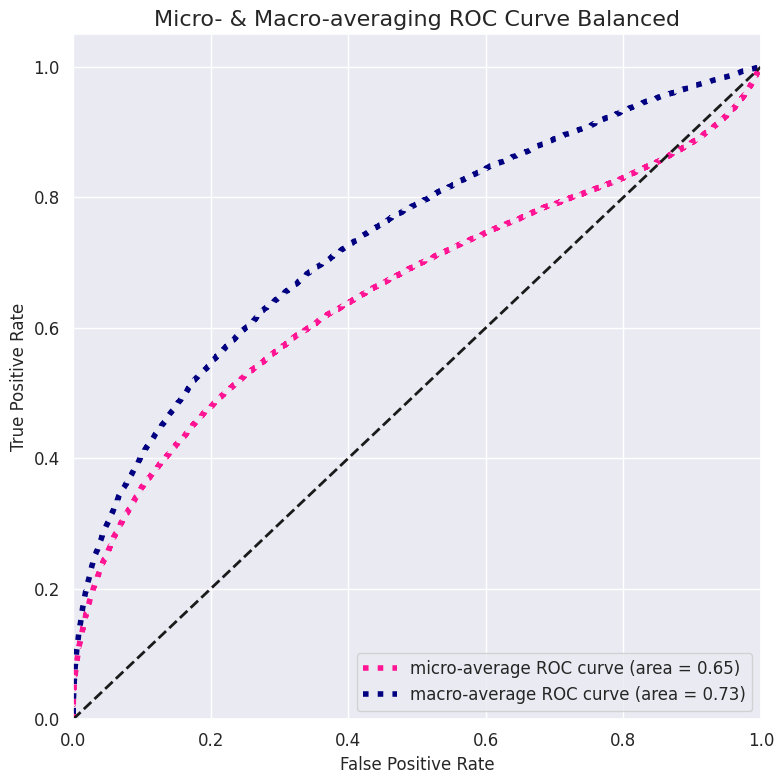

In [16]:
### Evaluate the best-performing model balanced using ROC curve

# Import module
import scikitplot as skplt

# Set seaborn styling
sns.set()

# Create a figure with specified size
plt.figure(0, (15, 5))

# Plot micro- and macro-averaging ROC curve
skplt.metrics.plot_roc(
    y_test,  # True labels (in one-hot encoded form)
    y_pred_prob,  # Predicted probabilities
    figsize=(8, 8),
    title='Micro- & Macro-averaging ROC Curve Balanced',
    plot_micro=True,
    plot_macro=True,
    classes_to_plot=labels.values(),  # Display ROC curves for each class
    cmap='nipy_spectral',
    title_fontsize=16,
    text_fontsize=12
)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as an image
plt.savefig("../images/roc_curve_best_model_balanced.png")

# Display the plot
plt.show()

In [17]:
# Compile the model once more (if model was loaded / skipped training)
keras_best_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Evaluate the final model using the train and test set.
print("Evaluating train_set ...")
train_loss, train_accuracy = keras_best_model.evaluate(train_set)
print("Evaluating test_set ...")
test_loss, test_accuracy   = keras_best_model.evaluate(test_set)
print("")
print("Final Results by evaluating model (batchsize = 1):")
print("Train accuracy = {:.2f}%".format(train_accuracy * 100))
print("Validation accuracy = {:.2f}%".format(test_accuracy * 100))

Evaluating train_set ...
547/547 [==============================] - 12s 21ms/step - loss: 0.5969 - accuracy: 0.7991
Evaluating test_set ...
17356/17356 [==============================] - 35s 2ms/step - loss: 4.1978 - accuracy: 0.3577

Final Results by evaluating model (batchsize = 1):
Train accuracy = 79.91%
Validation accuracy = 35.77%
